In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
class Mesh:
  def __init__(self, edges: torch.Tensor):
    self.edges = edges
    self.edge_lens = torch.norm(edges[:,0] - edges[:,1], dim=1)
  
  def loop(vertices):
    edges = torch.cat([vertices[:-1], vertices[1:]],dim=1).reshape(-1, 2, 2)
    return Mesh(edges)
  
  def plot(self, c='b'):
    for edge in self.edges:
      plt.plot(*edge.T, c)
    
  def pointcloud(self,n=1000,std = 0.01):
    edges_probs = self.edge_lens/self.edge_lens.sum()
    edges = torch.multinomial(edges_probs, n, replacement=True)
    edges = self.edges[edges]
    t = torch.rand(n)
    points = edges[:,0] + t[:,None]*(edges[:,1]-edges[:,0])
    noise = torch.randn_like(points)*std
    return points + noise
  


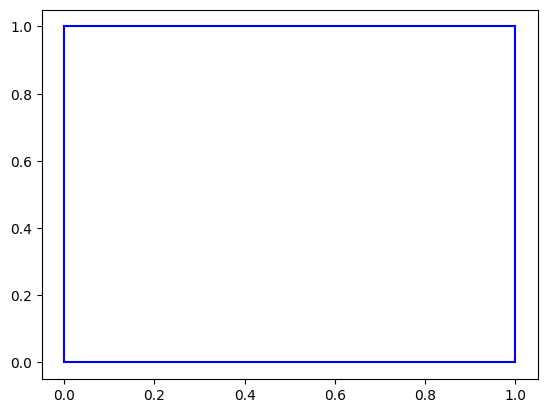

In [4]:
box = Mesh.loop(torch.tensor([[0, 0], [0, 1], [1, 1],[1,0], [0,0]],dtype=torch.float32))
box.plot()

In [5]:
def random_shape():
  n = np.random.randint(3, 10)
  corners = []

  for i in range(n):
    angle = 2*np.pi*i/n + np.random.rand()*0.1
    r = np.random.rand() * 0.5 + 0.5
    corners.append(torch.tensor([np.cos(angle)*r, np.sin(angle)*r],dtype=torch.float32))

  verts = []
  corner_dir = np.random.randint(2)
  for i in range(n + 1):
    verts.append(corners[i % n])
    verts.append(torch.tensor([corners[(i+corner_dir) % n][0] , corners[(i + 1 - corner_dir) % n][1]]))
    

  return Mesh.loop(torch.stack(verts[:-1]))



# v = shape.pointcloud(200)
# plt.scatter(*v.T)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image

def create_filled_binary_image(shape, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    vertices = np.vstack([shape.edges[:, 0].numpy(), shape.edges[-1, 1].numpy()])  # Collect vertices
    number_of_edges = vertices.size/2
    polygon = Polygon(vertices, closed=True, fill=True, color='black')  # Create and add the polygon
    ax.add_patch(polygon)
    ax.set_xlim(vertices[:, 0].min() - 0.1, vertices[:, 0].max() + 0.1)
    ax.set_ylim(vertices[:, 1].min() - 0.1, vertices[:, 1].max() + 0.1)
    ax.axis('off')

    # Save the figure to a PIL Image and convert to binary
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image = Image.fromarray(image).convert('L').point(lambda x: 255 if x > 128 else 0, '1')  #with this the image wil be binary and not rgb 255 means full black, 128 means closer to white then black

    #plt.close(fig)  # Close the plot
    return image, number_of_edges


In [10]:
binary_image

(<PIL.Image.Image image mode=1 size=600x600>, 9.0)

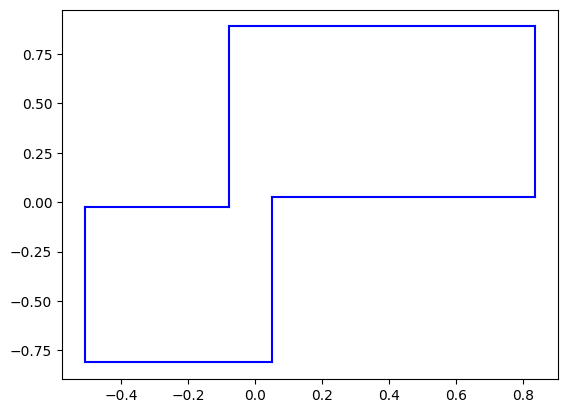

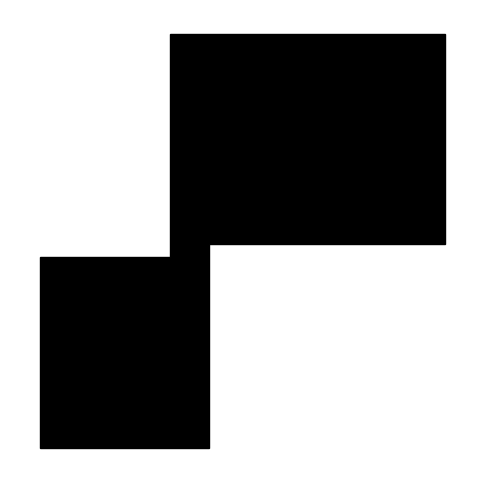

In [9]:
shape = random_shape()
shape.plot()
binary_image = create_filled_binary_image(shape)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image

def create_image_with_noise(shape, edge_indices, num_points=1000, noise_radius=0.1, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)     # set the axis the same as figsize
    
    # Put vertices in an array
    vertices = np.vstack([shape.edges[:, 0].numpy(), shape.edges[-1, 1].numpy()])
    polygon = Polygon(vertices, closed=True, fill=True, color='black')
    ax.add_patch(polygon)
    ax.axis('off')

    for edge_index in edge_indices: 
        edge_start = shape.edges[edge_index, 0].numpy()
        edge_end = shape.edges[edge_index, 1].numpy() # coordinates fo the beginning and end of the edge
        edge_vector = edge_end - edge_start # indicates the direction of the noise
        normal_vector = np.array([-edge_vector[1], edge_vector[0]])
        normal_vector /= np.linalg.norm(normal_vector)

        # Genera punti di rumore
        t = np.random.uniform(0, 1, num_points)
        noise_points = (edge_start + t[:, np.newaxis] * edge_vector) + normal_vector * np.random.normal(0, noise_radius, num_points)[:, np.newaxis]
        
        # Traccia i punti di rumore
        ax.scatter(noise_points[:, 0], noise_points[:, 1], color='black', s=1)
    
    # Set plot limits so the visualization will be all visible
    buffer = 0.2
    ax.set_xlim(vertices[:, 0].min() - buffer, vertices[:, 0].max() + buffer)
    ax.set_ylim(vertices[:, 1].min() - buffer, vertices[:, 1].max() + buffer)
    ax.axis('off')

    # convert to binary
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image = Image.fromarray(image).convert('L').point(lambda x: 255 if x > 128 else 0, '1')

    plt.close(fig)  # show only once
    return image


/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/4030735793.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


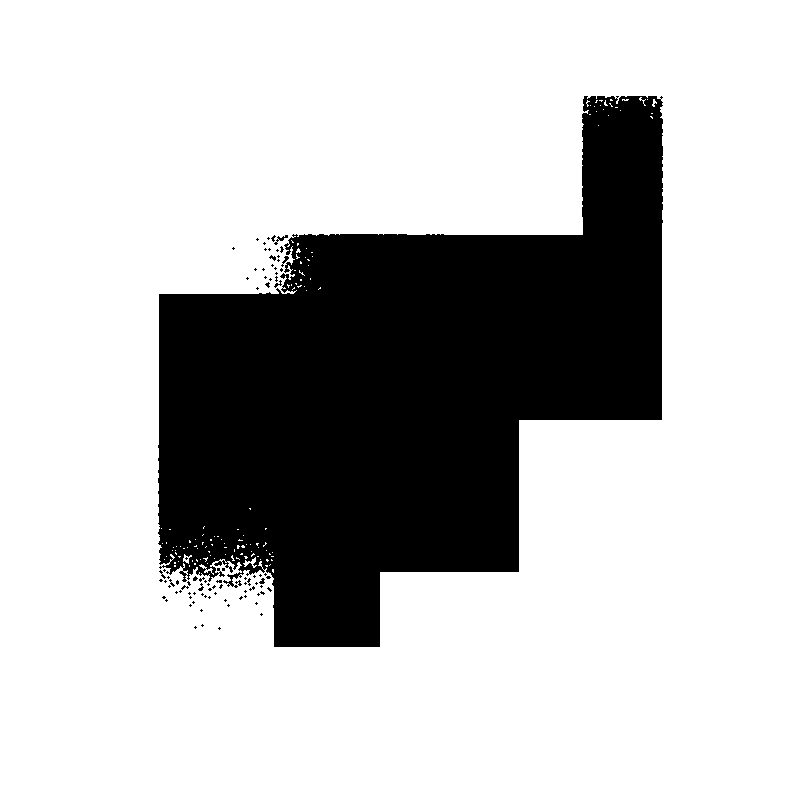

In [8]:
image = create_image_with_noise(shape, (1,4,7), num_points=10000, noise_radius=0.1, figsize=(8, 8))
image

/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/2503524007.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  modified_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


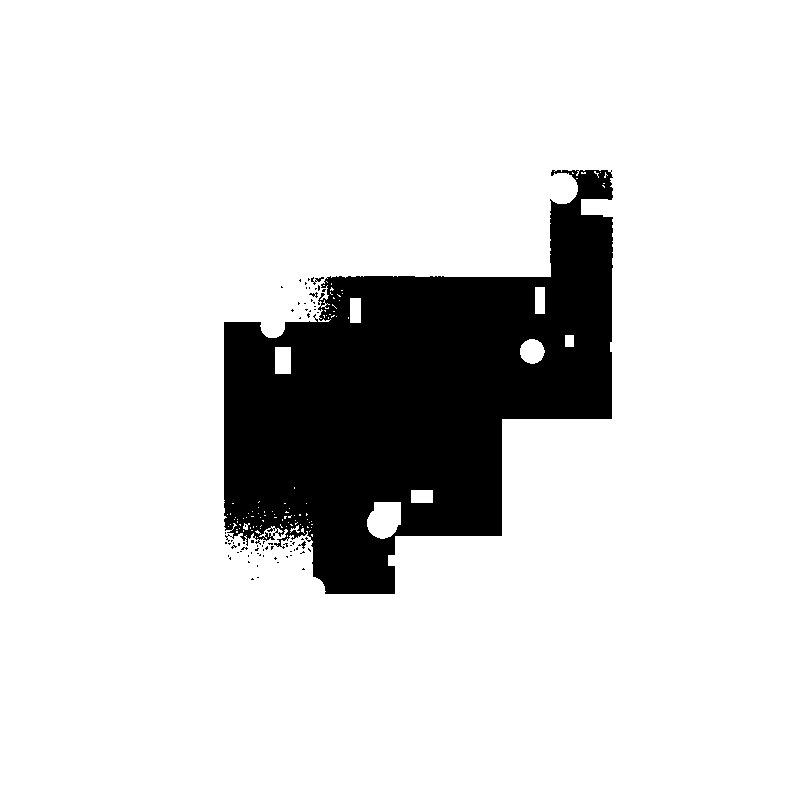

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, Rectangle
from PIL import Image

def add_random_shapes_to_image(image, num_shapes=40, figsize=(8, 8)):
    # Converti l'immagine PIL in un array di numpy per lavorarci su matplotlib
    data = np.array(image)
    
    # Crea un plot con l'immagine esistente
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(data, cmap='gray', interpolation='none')
    ax.axis('off')  # Nasconde gli assi per una visualizzazione migliore
    
    # Ottieni le dimensioni dell'immagine
    height, width = data.shape
    
    # Genera e disegna figure geometriche casuali
    for _ in range(num_shapes):
        shape_type = np.random.choice(['circle', 'square'])
        x, y = np.random.uniform(0, width), np.random.uniform(0, height)
        
        if shape_type == 'circle':
            radius = np.random.uniform(5, 20)  # Imposta un raggio casuale
            circle = Circle((x, y), radius, color='white', fill=True)
            ax.add_patch(circle)
        elif shape_type == 'square':
            side1 = np.random.uniform(10, 40)
            side2 = np.random.uniform(10, 40)  # Imposta la lunghezza del lato casuale
            square = Rectangle((x - side1, y - side2), side1, side2, color='white', fill=True)
            ax.add_patch(square)
    
    # Salva la figura modificata in una nuova immagine PIL
    fig.canvas.draw()
    modified_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    modified_image = modified_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)  # Chiudi il plot per non mostrare la figura
    return Image.fromarray(modified_image).convert('L').point(lambda x: 255 if x > 128 else 0, '1')

# Esempio di utilizzo:
# image = Image.open('path_to_your_binary_image.jpg')
image_with_forniture = add_random_shapes_to_image(image)
image_with_forniture


/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/1389876764.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/4030735793.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/2503524007.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  modified_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


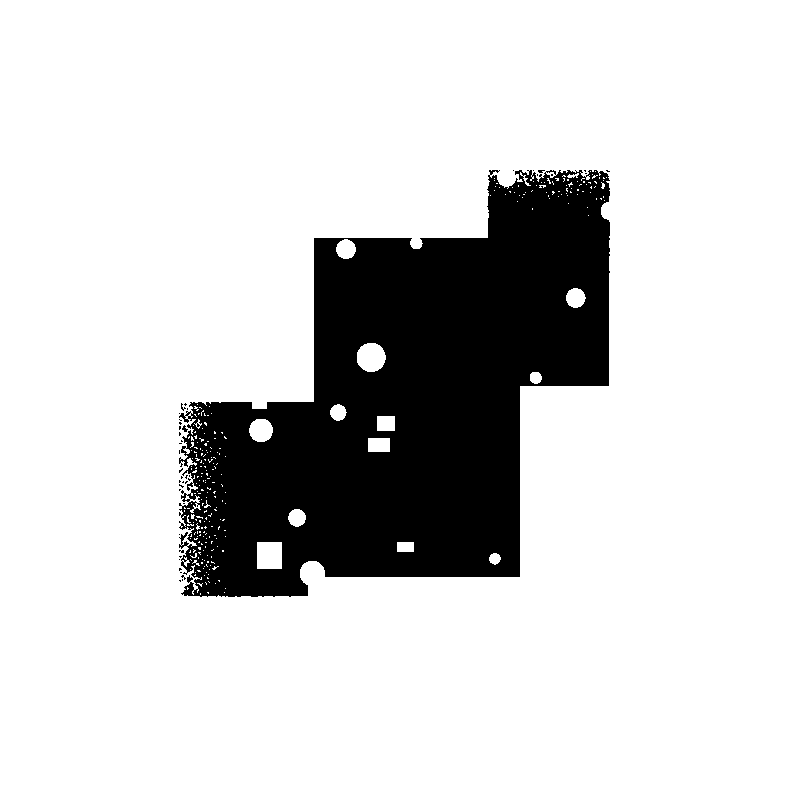

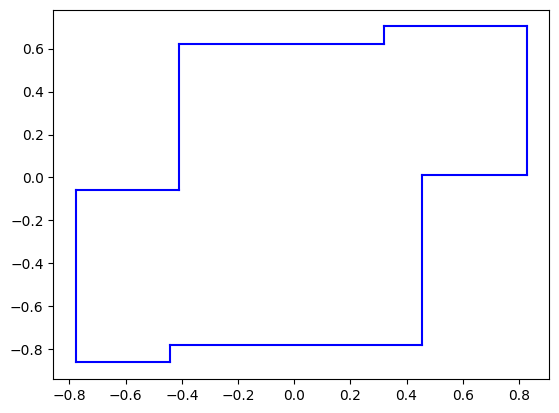

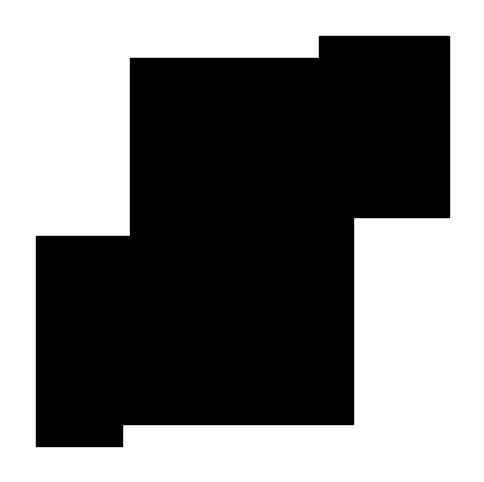

In [10]:

shape = random_shape()
shape.plot()
binary_image = create_filled_binary_image(shape)
image_with_noise = create_image_with_noise(shape, (1,6), num_points=10000, noise_radius=0.1, figsize=(8, 8))
image_with_noise
image_with_forniture = add_random_shapes_to_image(image_with_noise)
image_with_forniture

In [11]:
'''
shape = random_shape()
shape.plot()
binary_image = create_filled_binary_image(shape)
image = create_image_with_noise(shape, (1,7), num_points=10000, noise_radius=0.1, figsize=(8, 8))
image
image_with_forniture = add_random_shapes_to_image(image)
image_with_forniture
'''

'\nshape = random_shape()\nshape.plot()\nbinary_image = create_filled_binary_image(shape)\nimage = create_image_with_noise(shape, (1,7), num_points=10000, noise_radius=0.1, figsize=(8, 8))\nimage\nimage_with_forniture = add_random_shapes_to_image(image)\nimage_with_forniture\n'

/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/4030735793.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/99/bnpgw6zx68v52nbcw2mjn_qh0000gn/T/ipykernel_4611/2503524007.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  modified_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


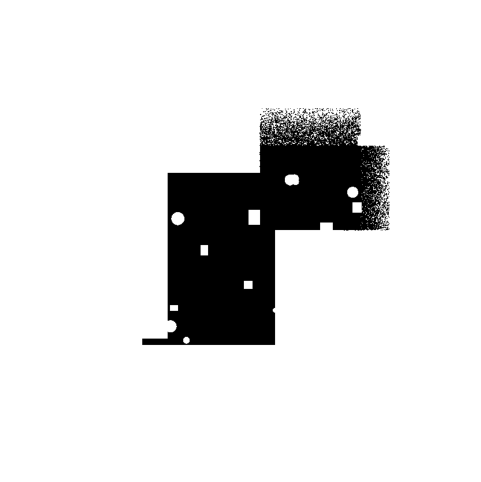

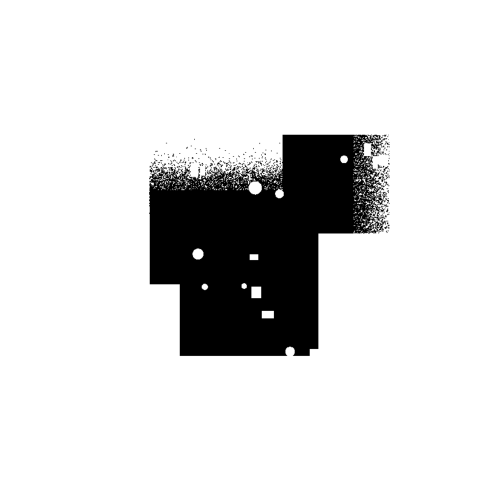

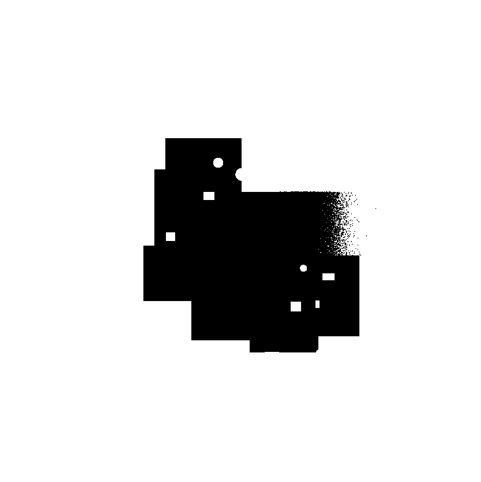

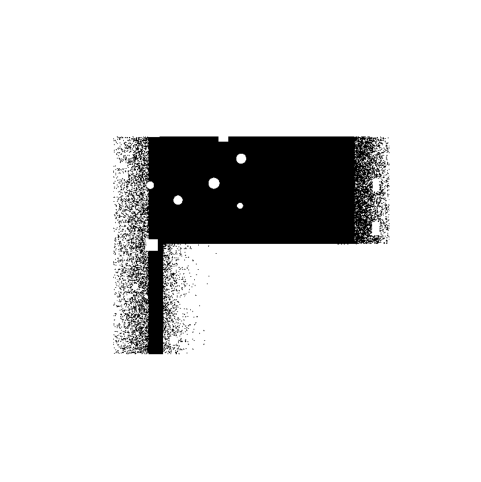

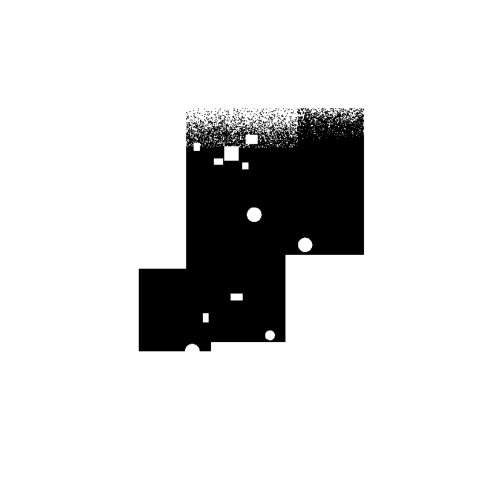

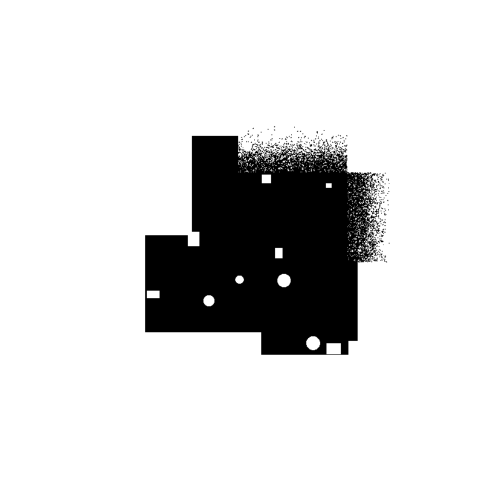

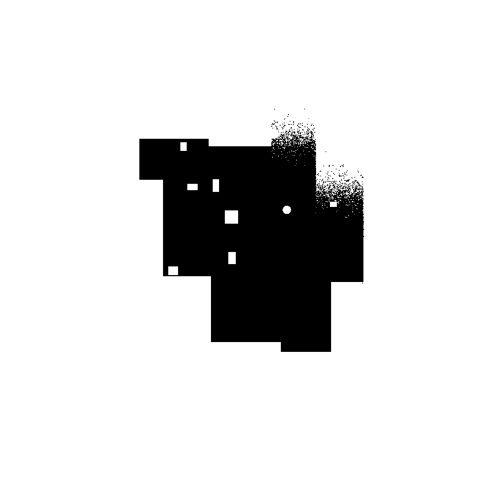

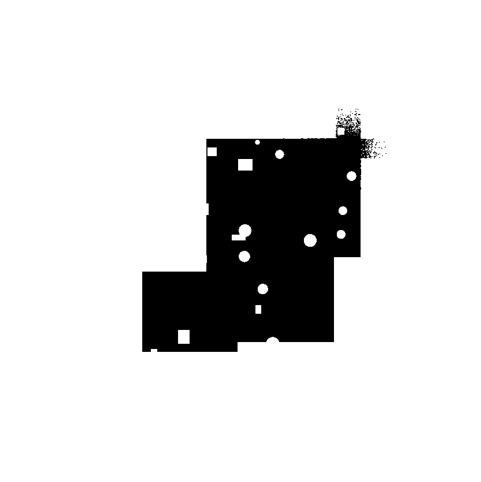

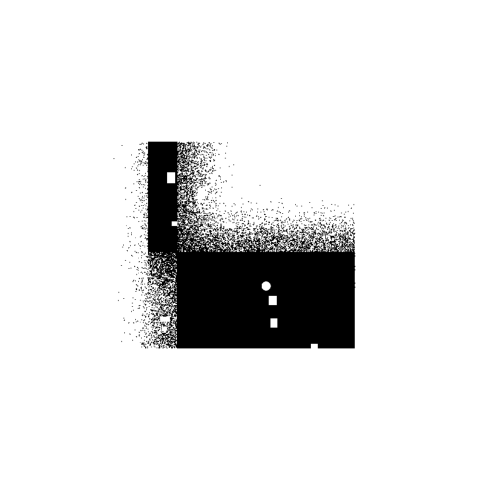

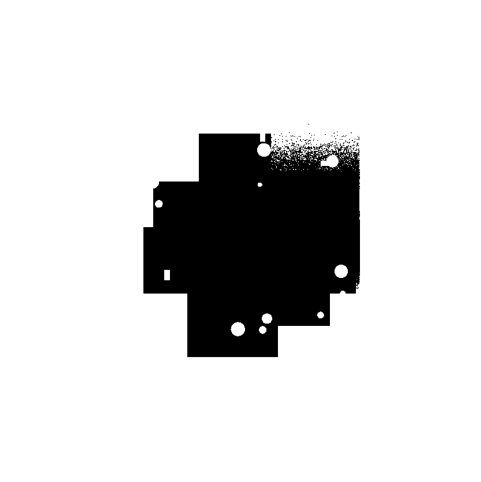

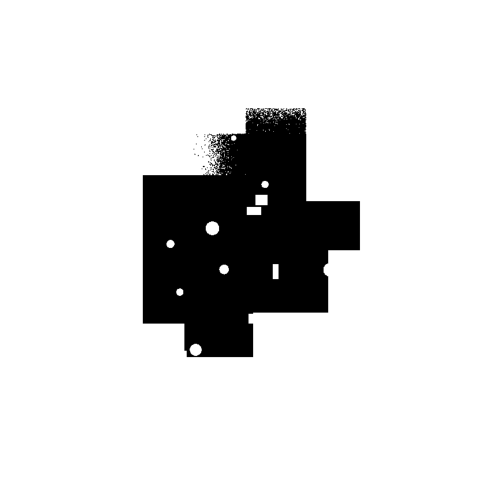

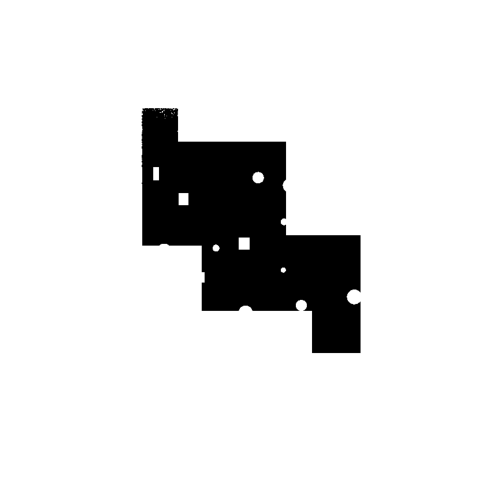

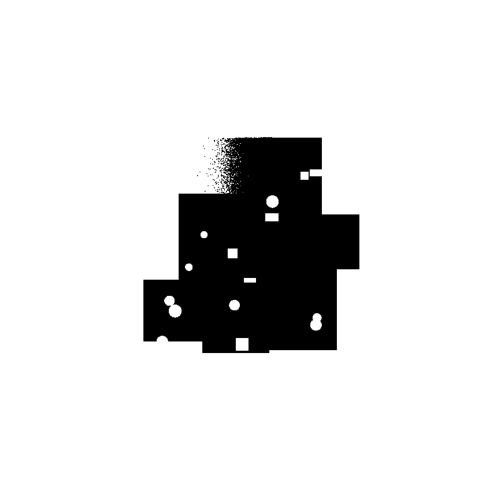

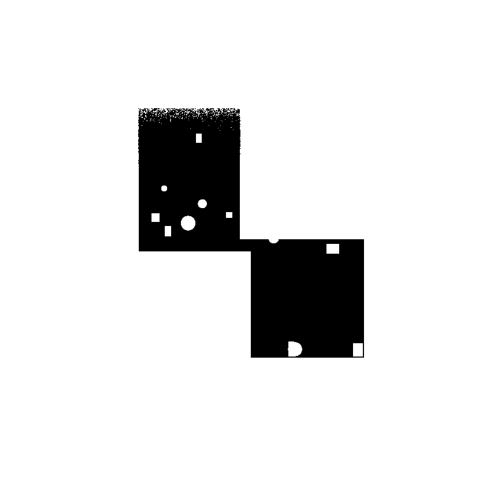

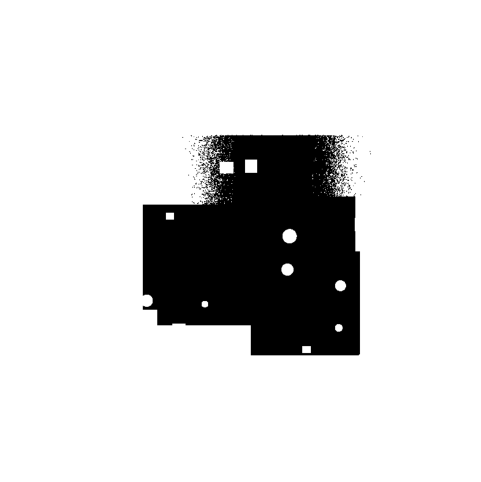

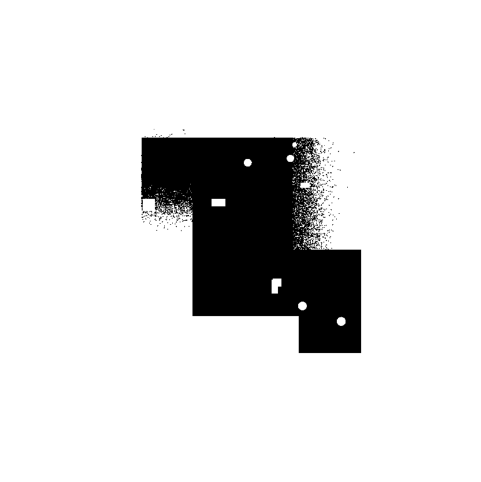

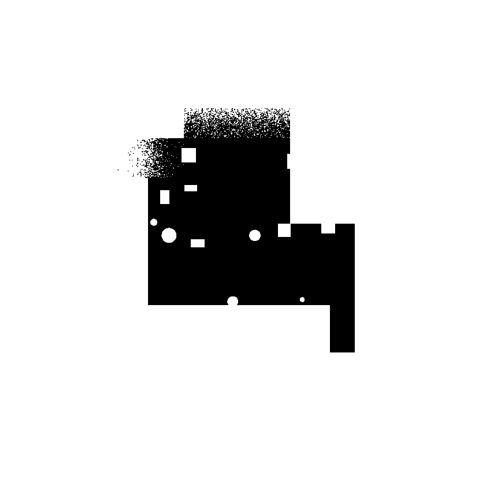

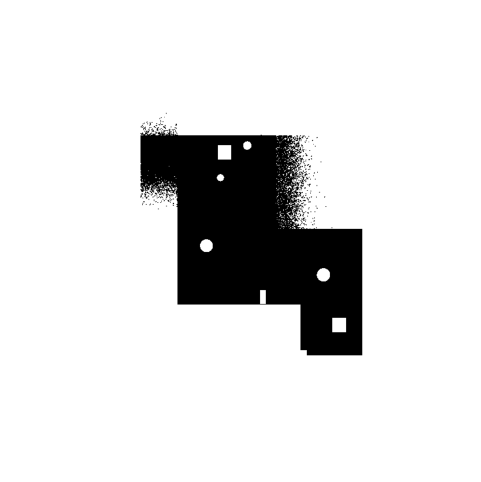

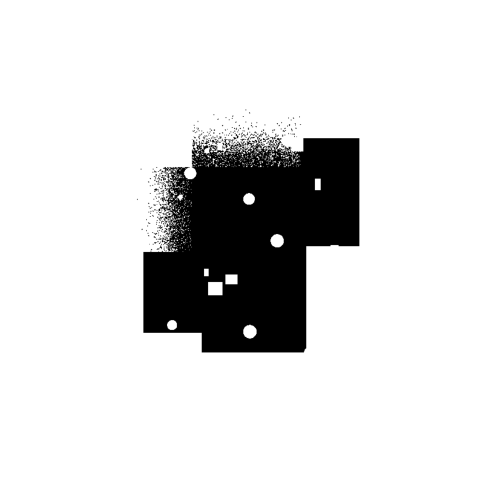

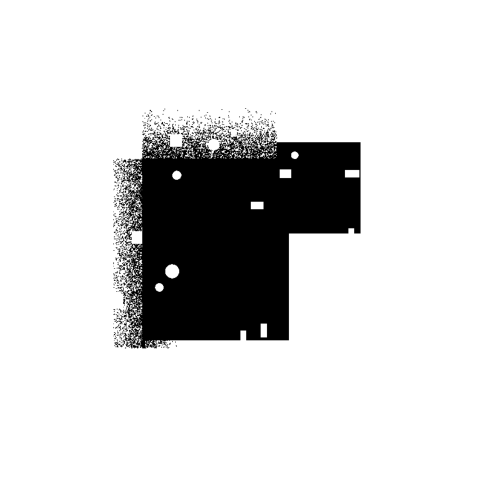

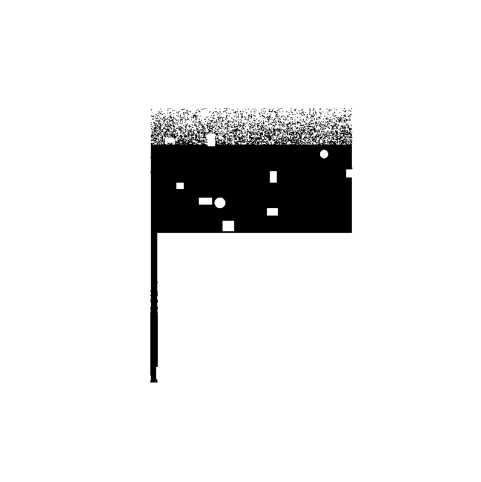

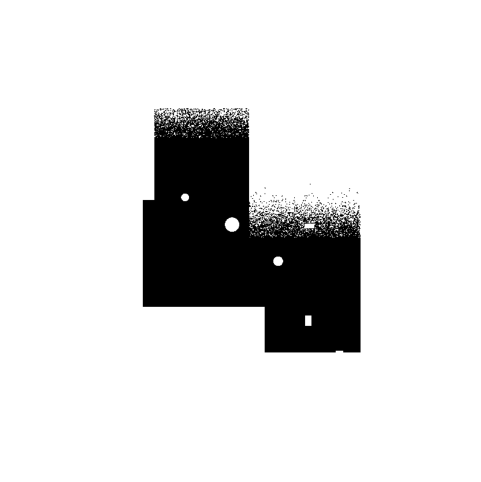

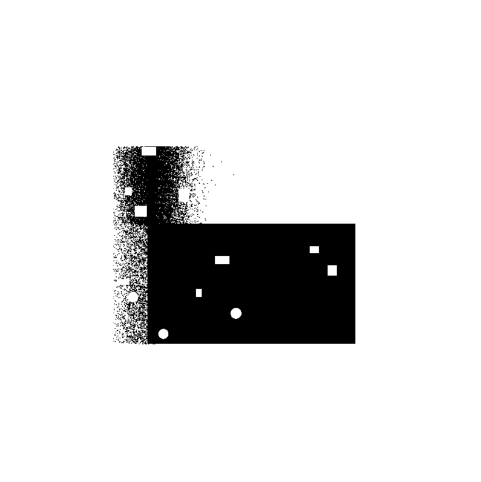

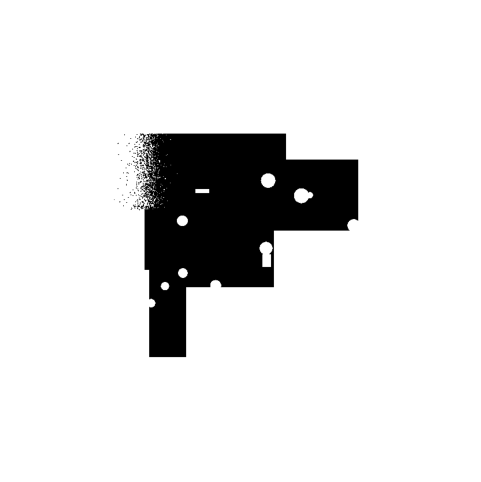

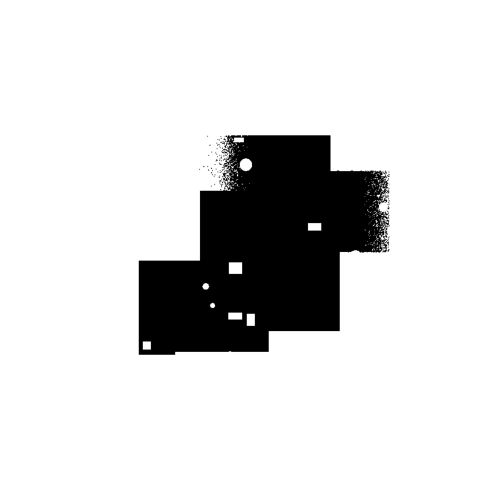

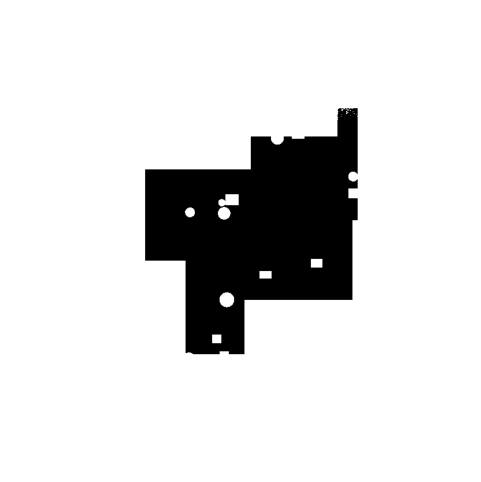

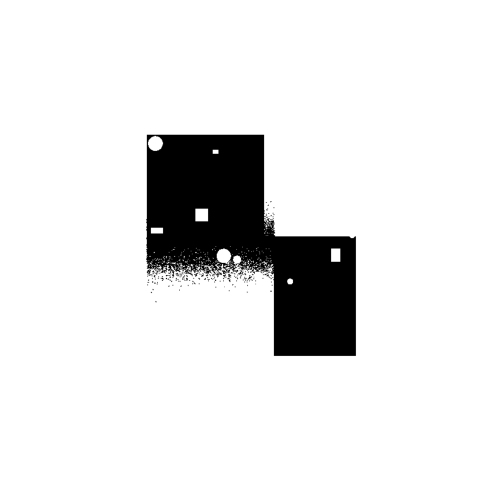

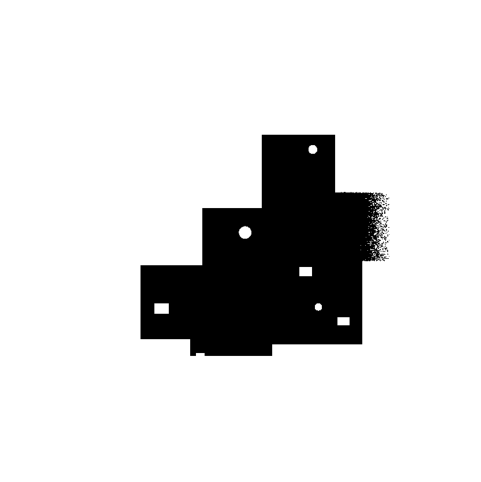

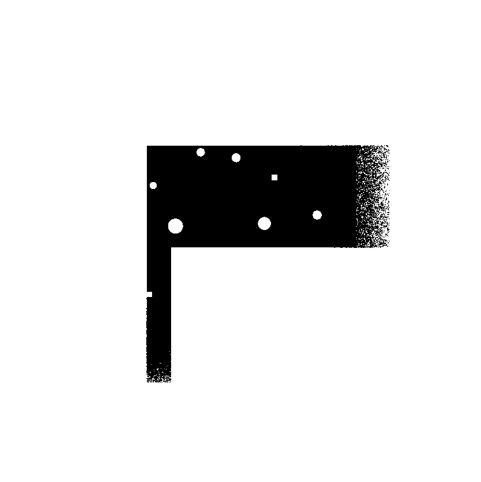

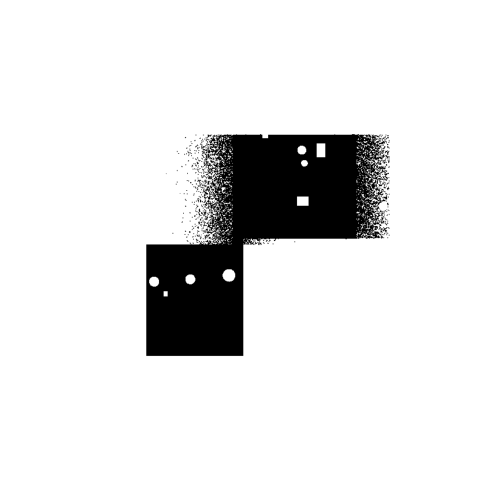

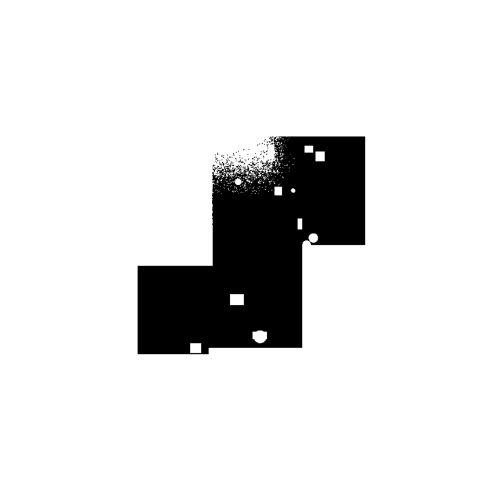

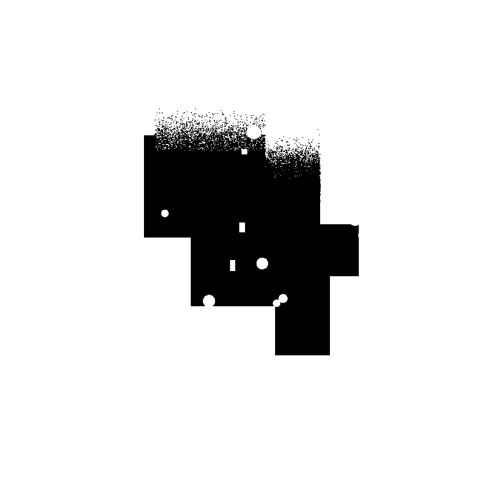

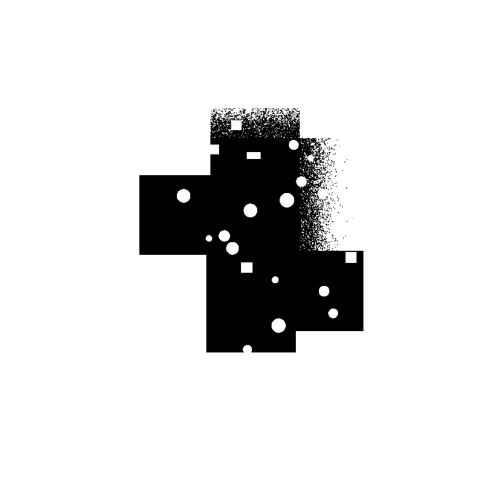

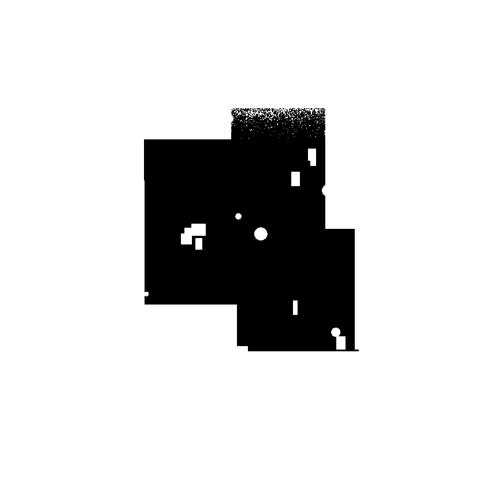

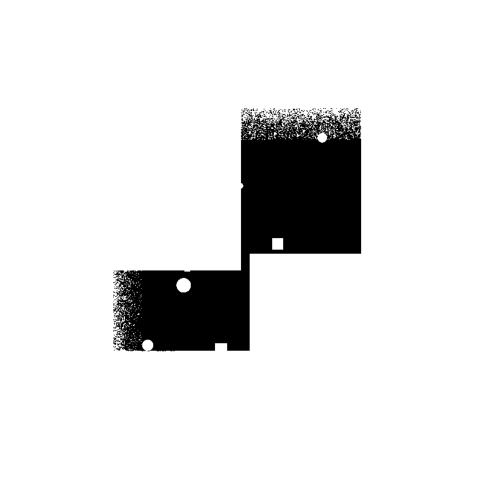

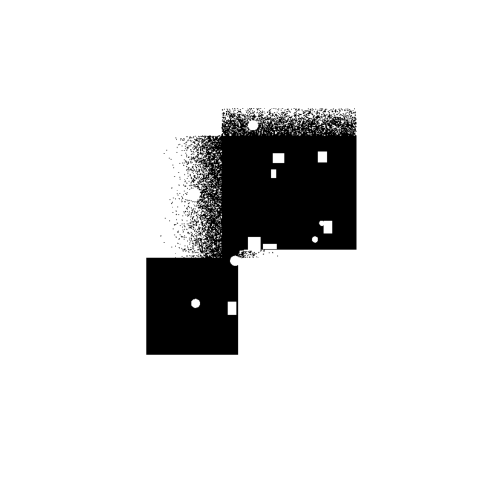

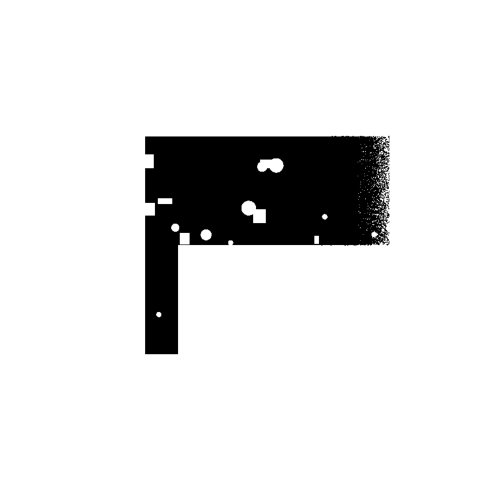

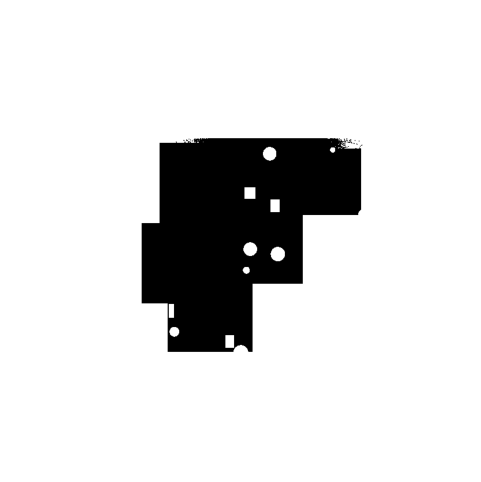

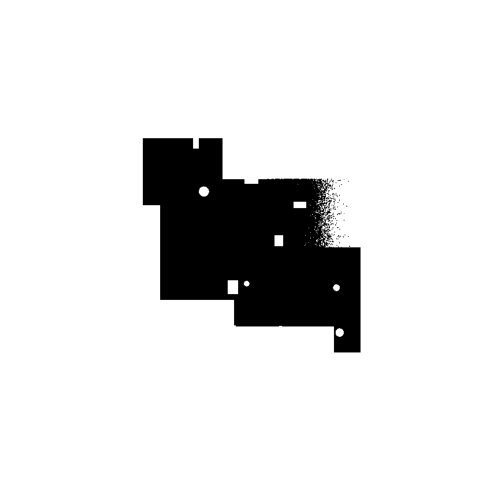

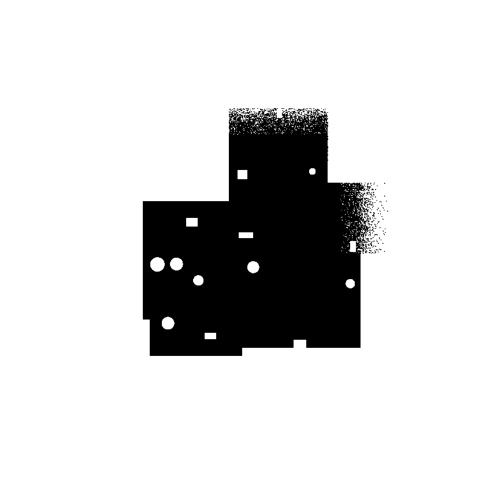

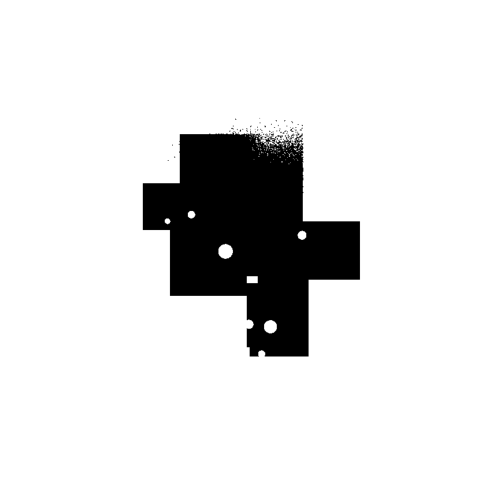

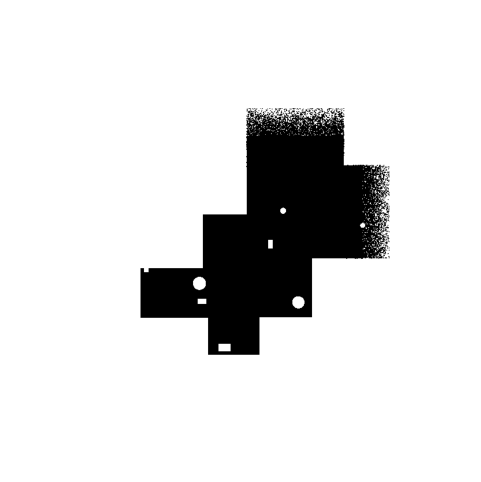

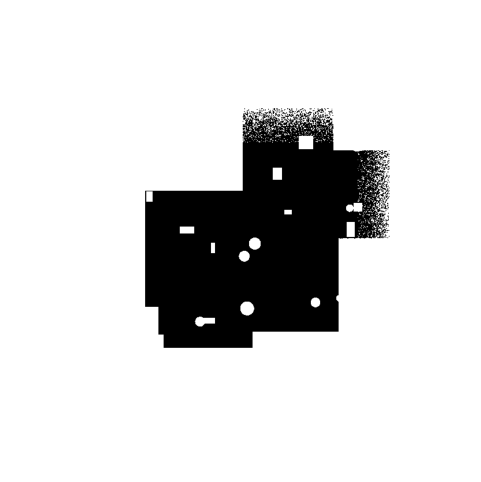

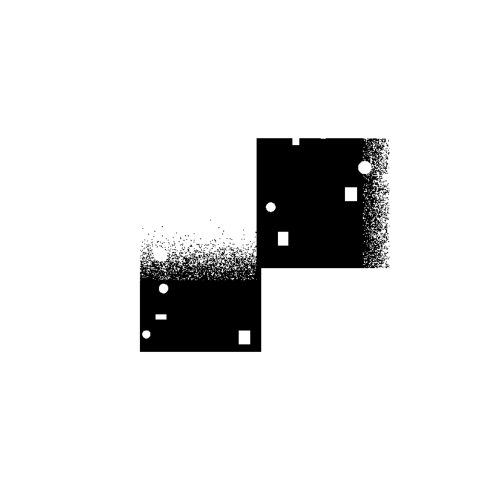

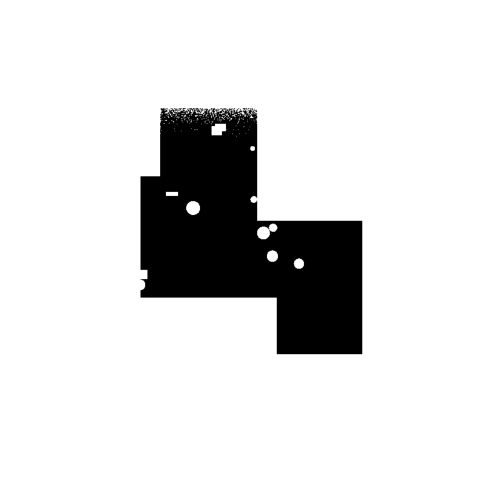

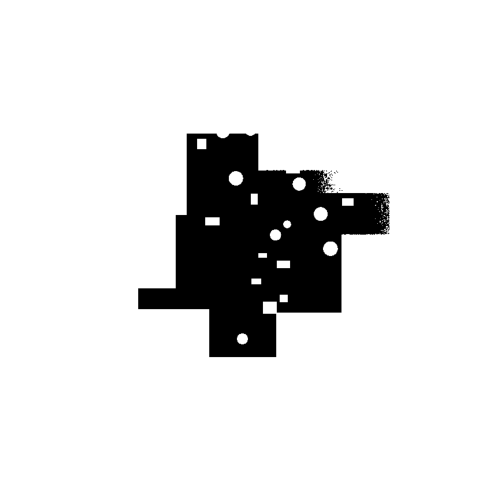

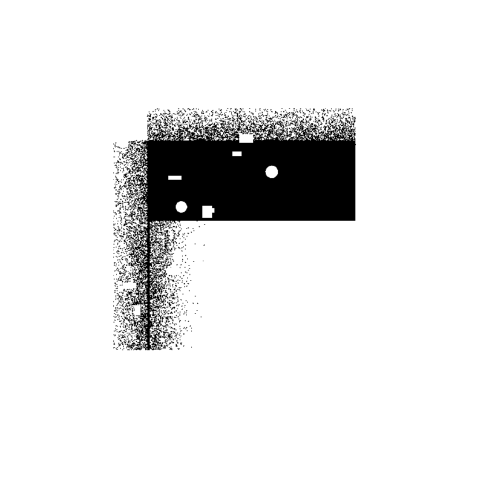

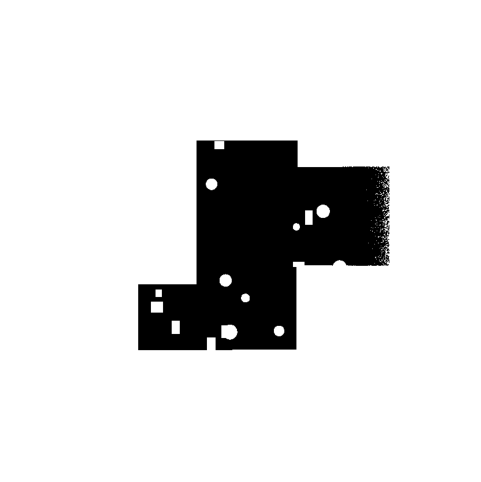

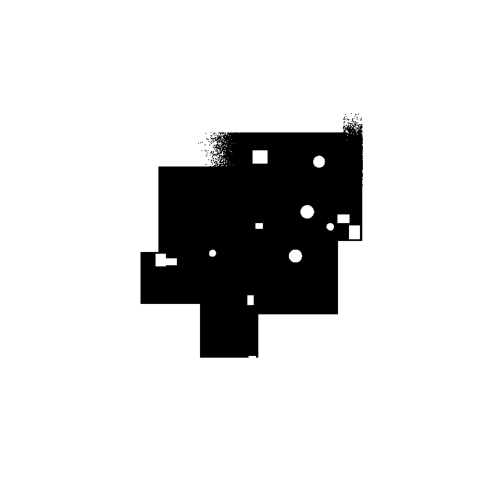

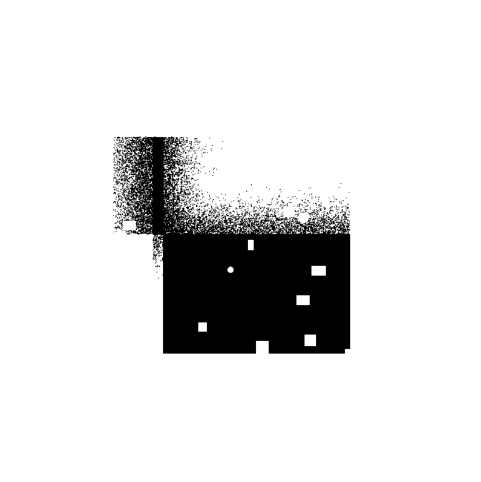

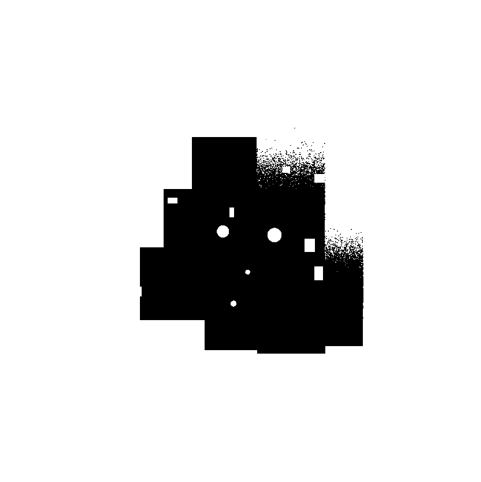

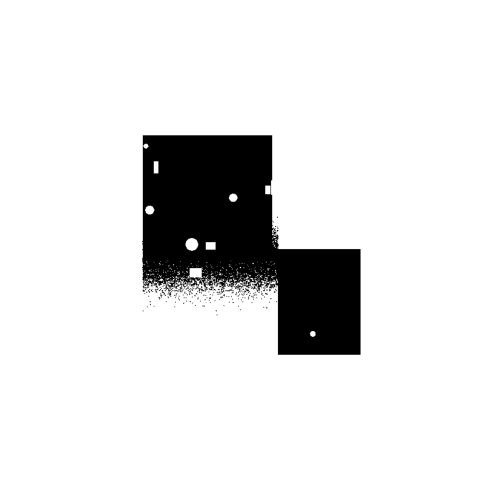

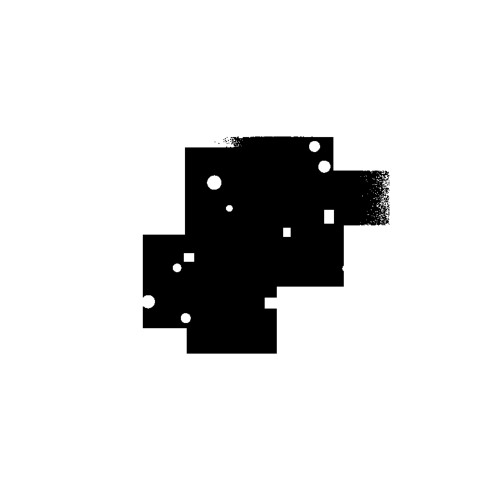

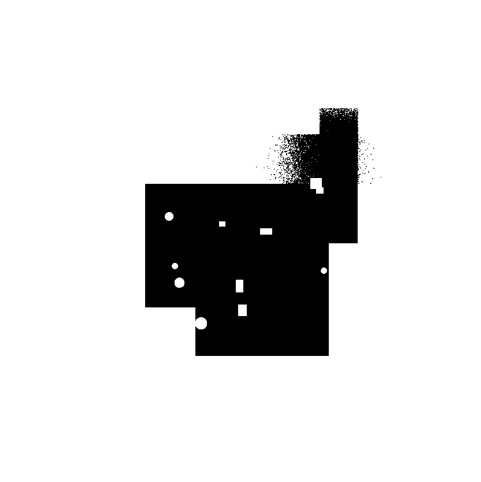

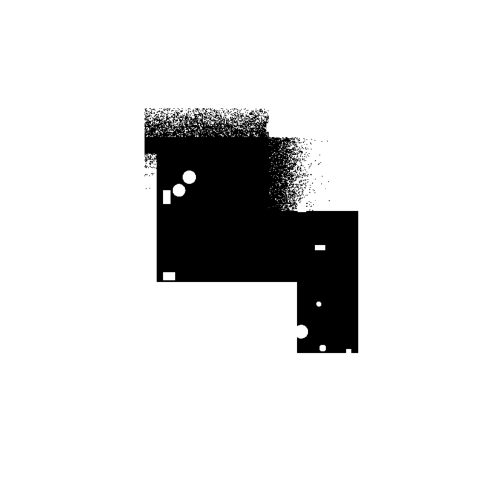

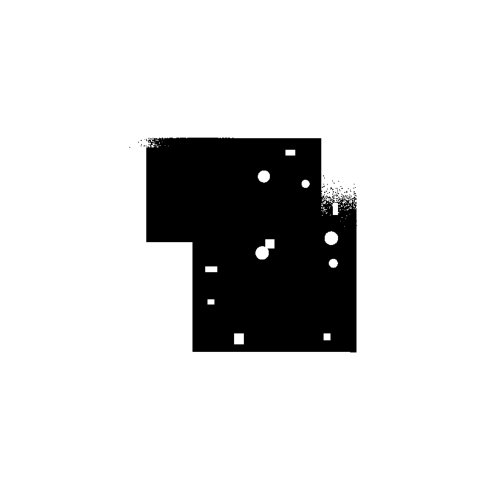

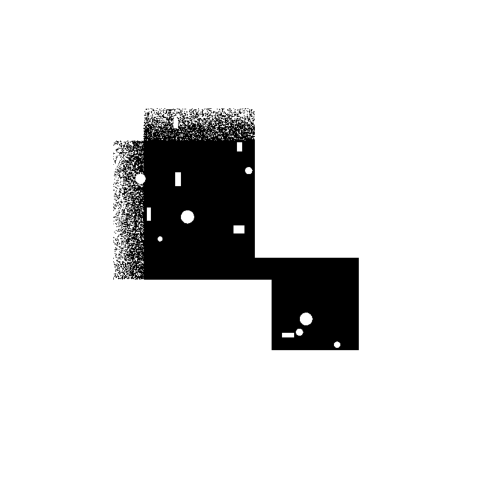

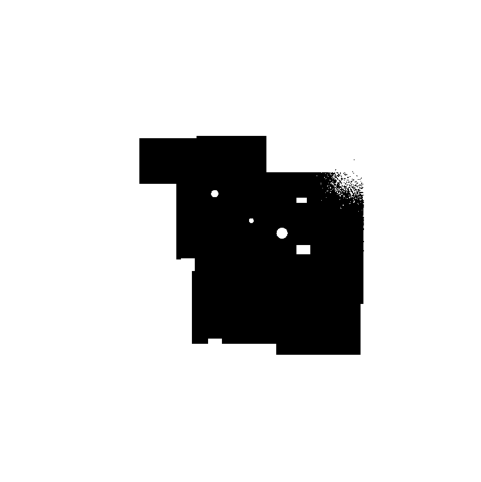

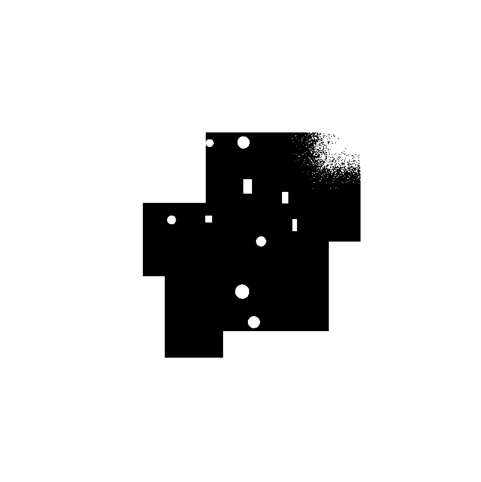

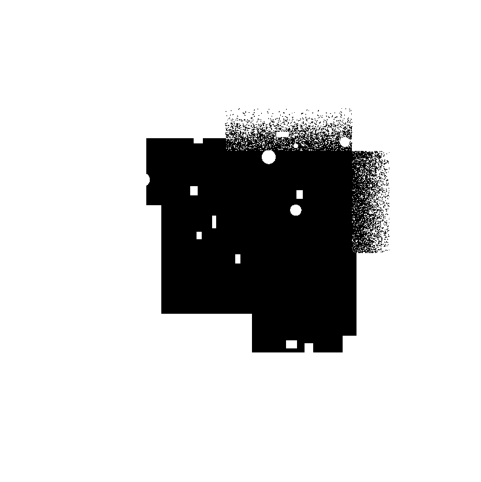

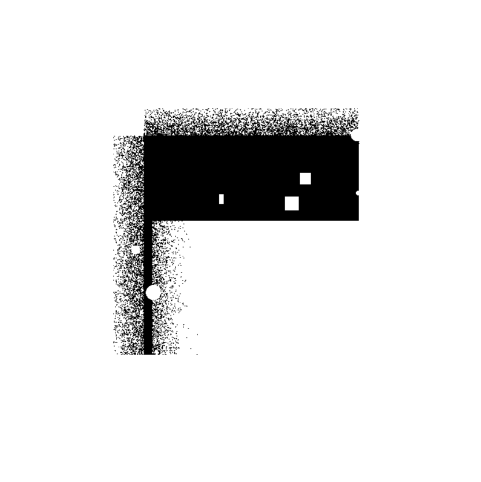

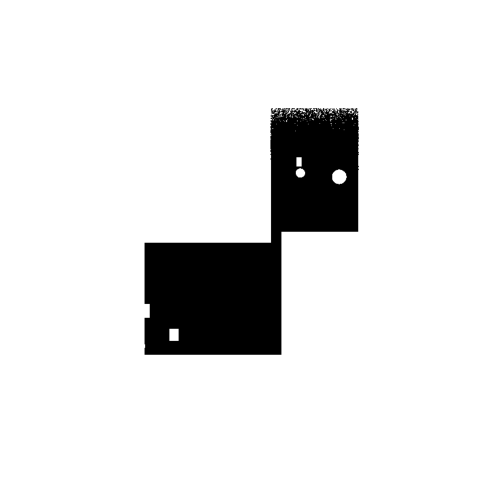

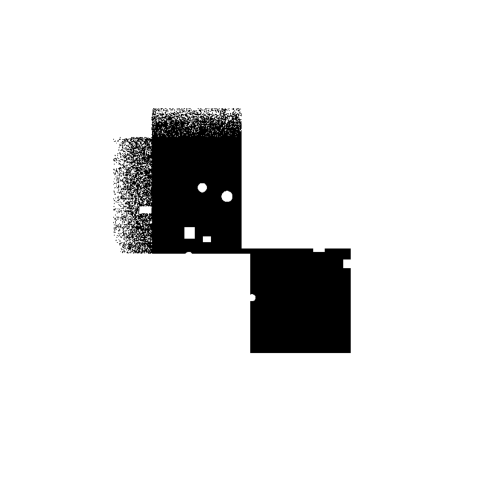

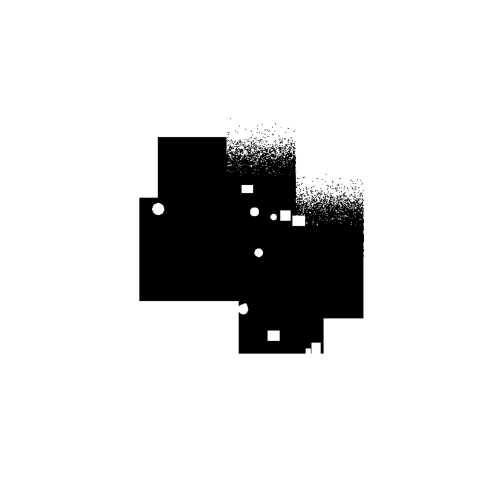

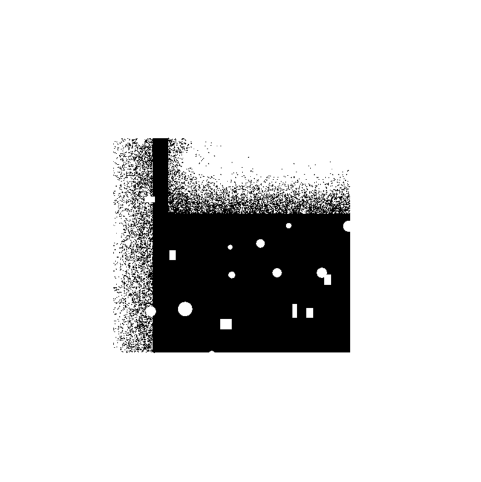

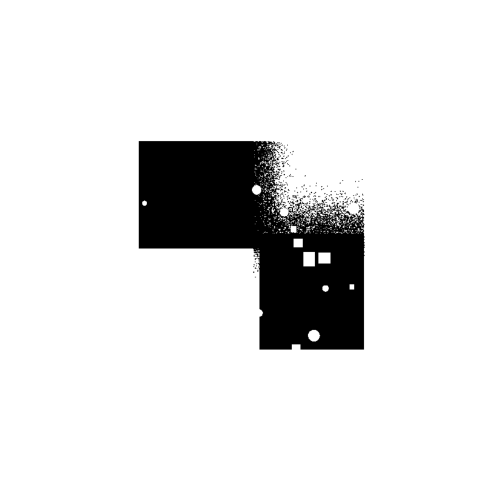

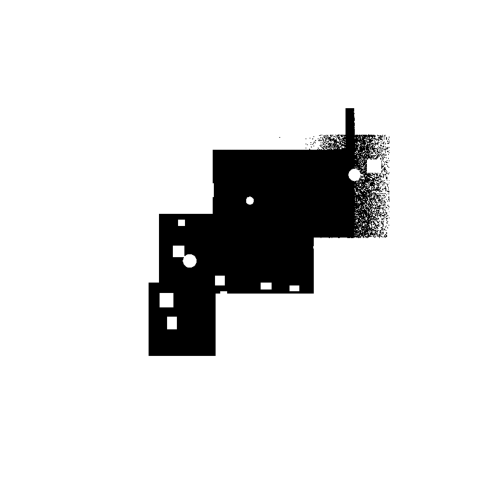

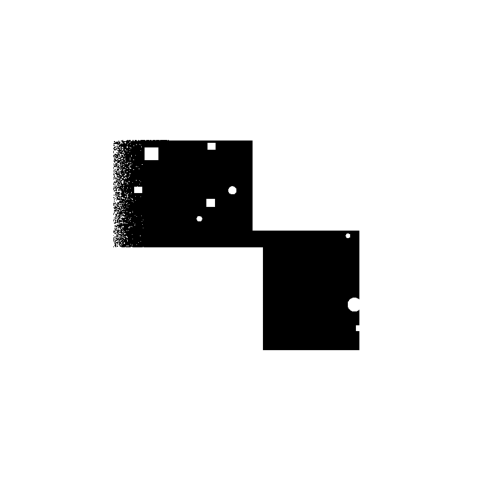

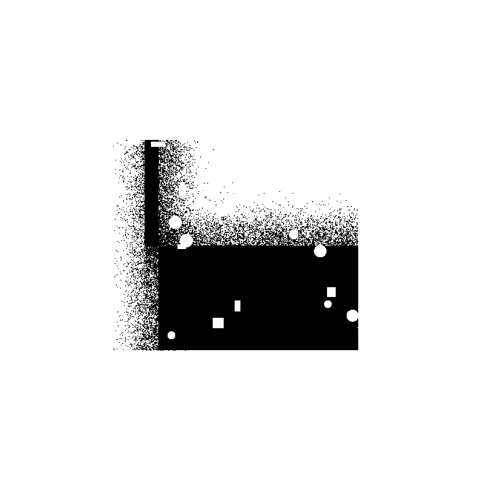

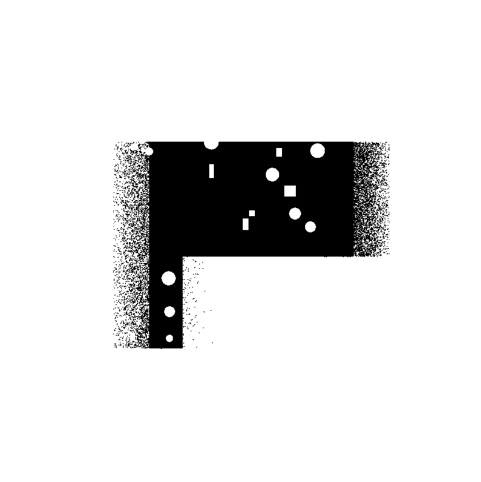

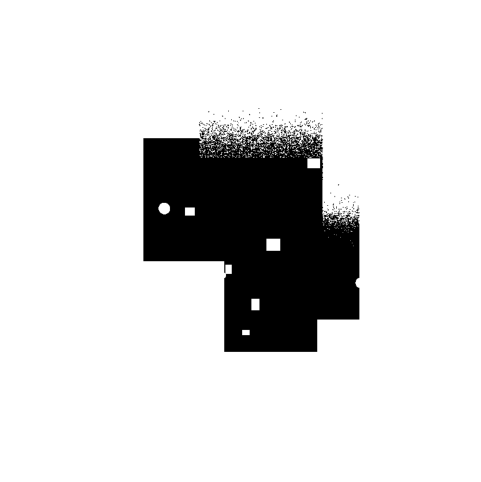

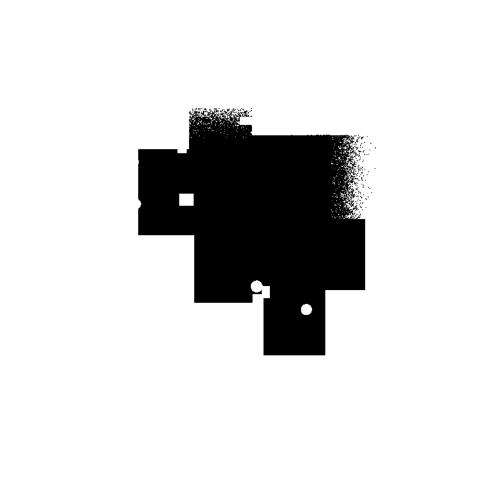

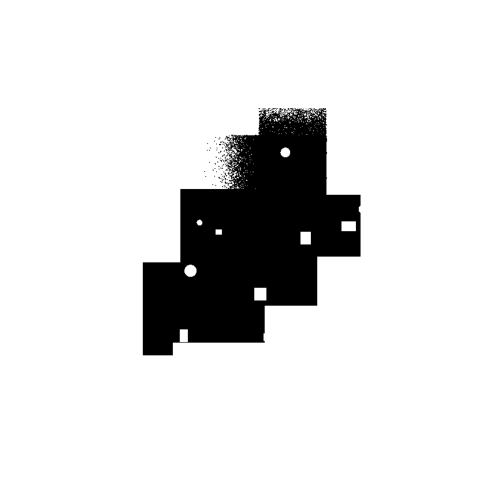

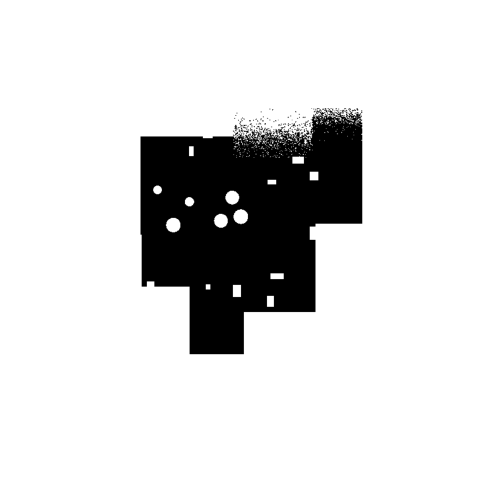

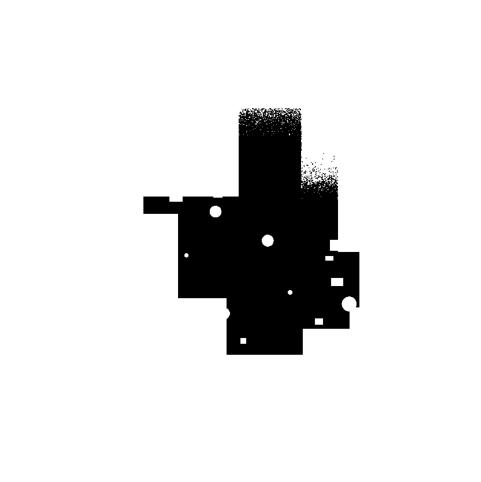

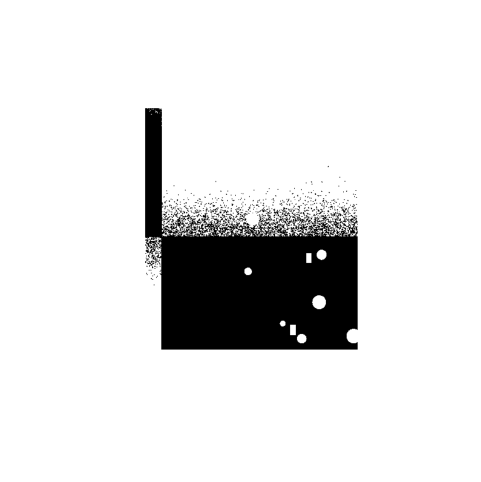

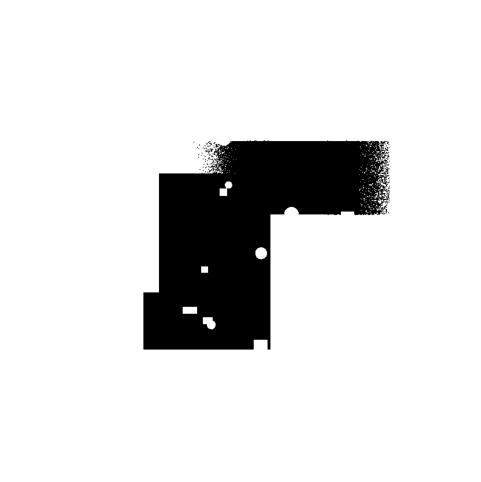

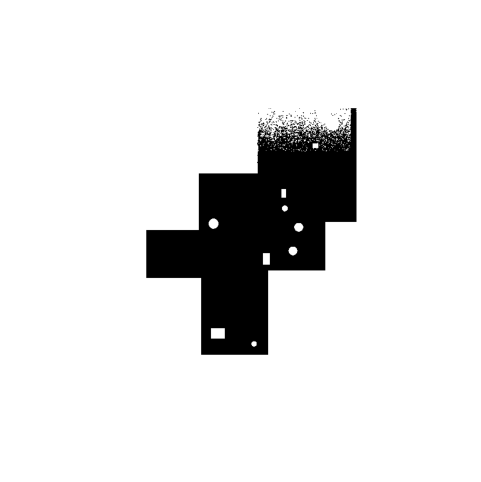

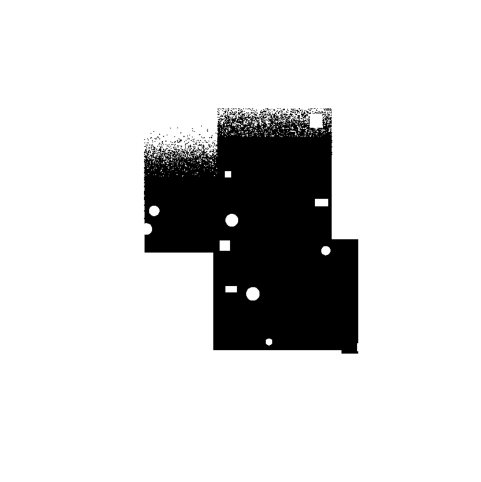

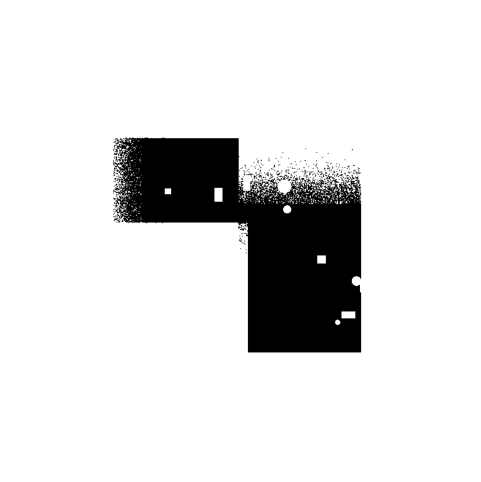

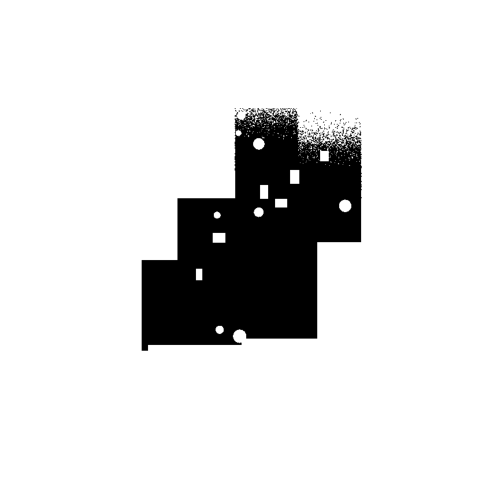

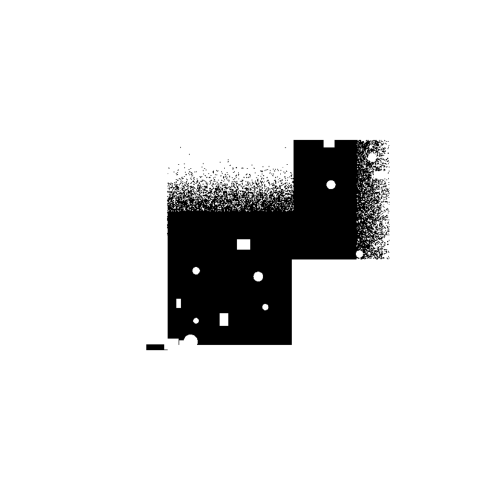

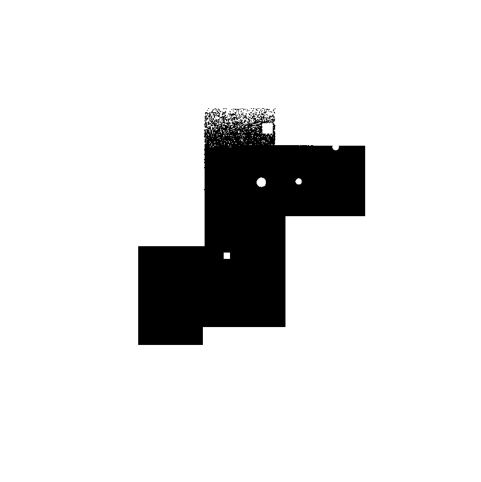

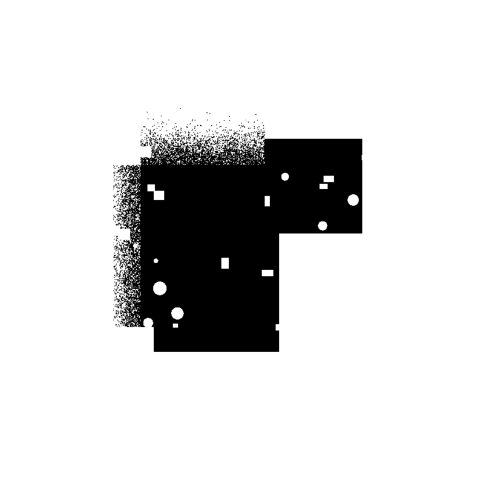

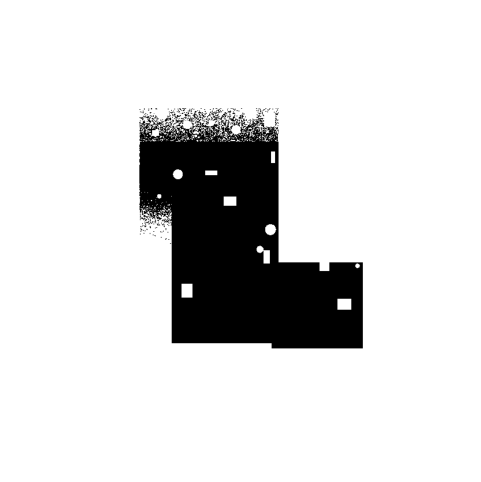

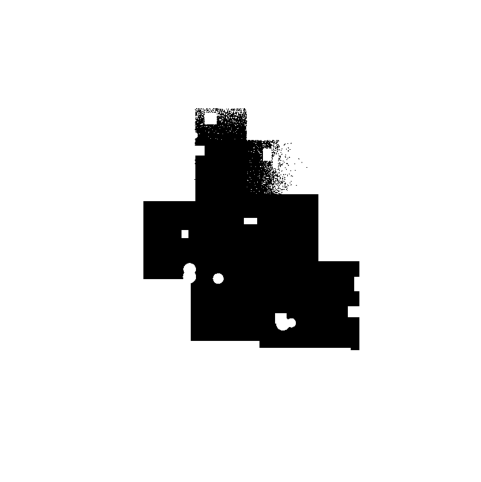

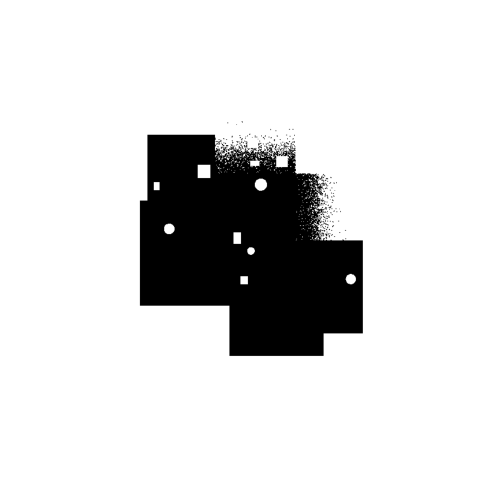

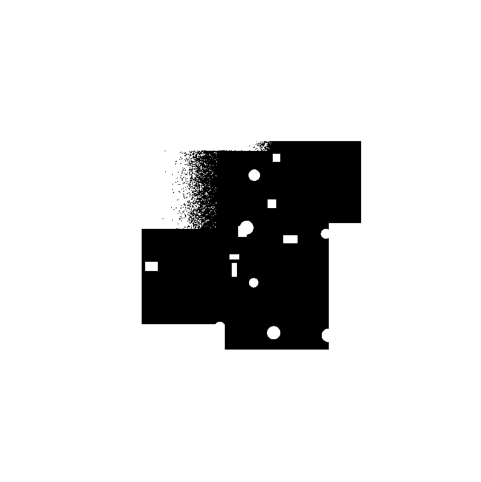

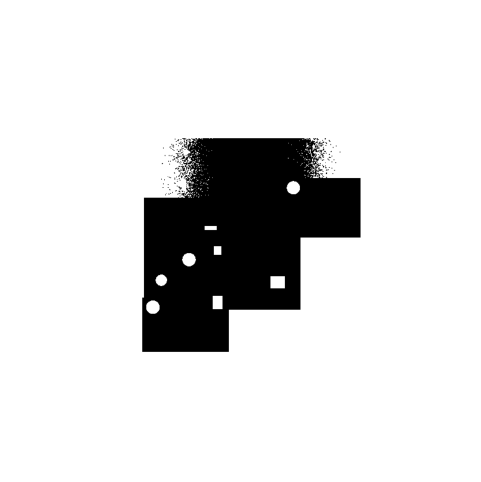

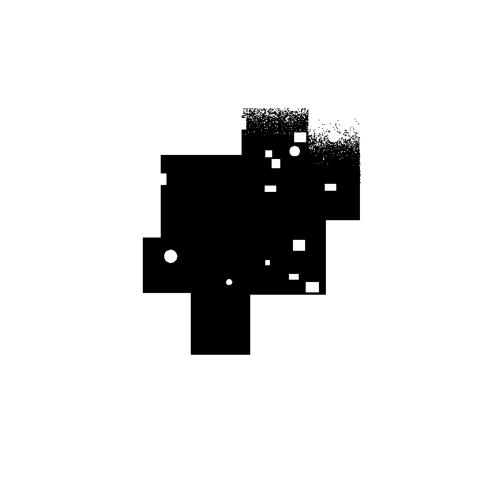

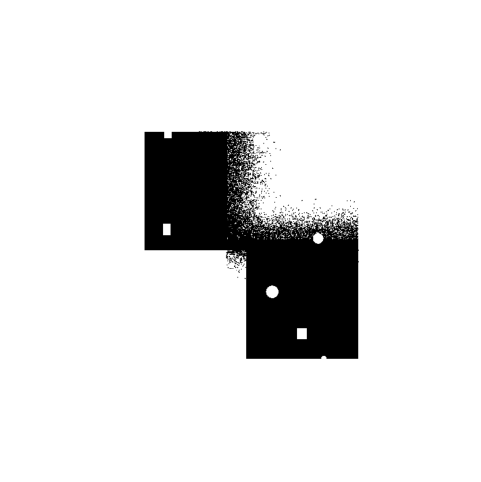

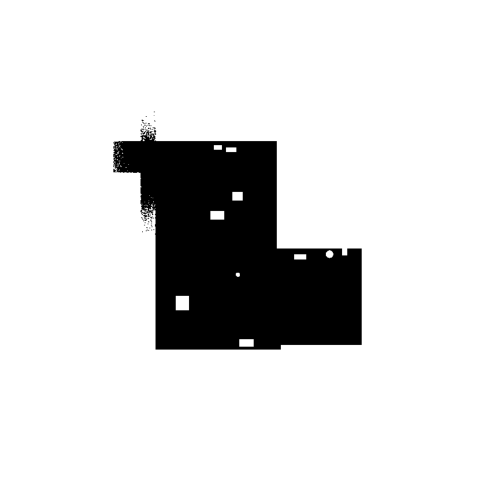

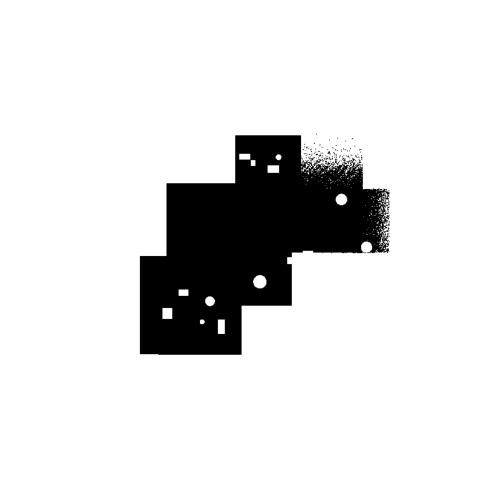

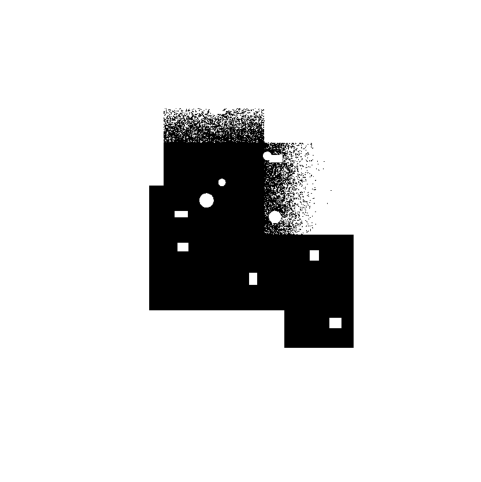

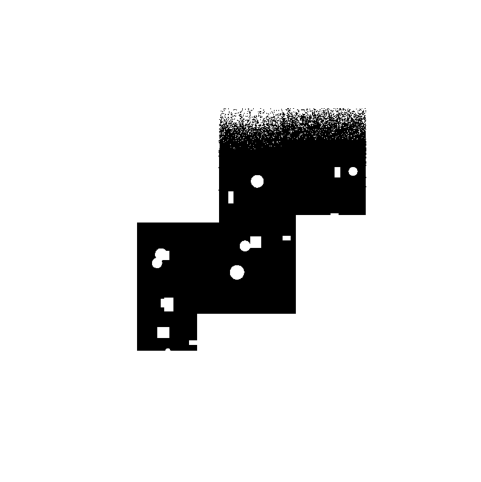

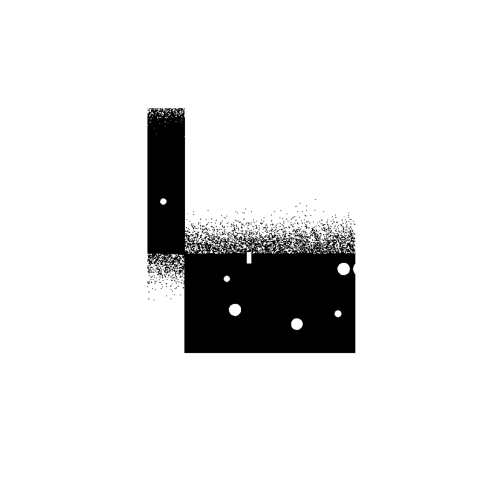

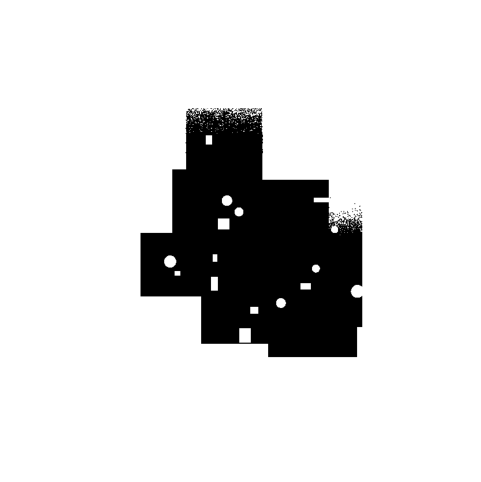

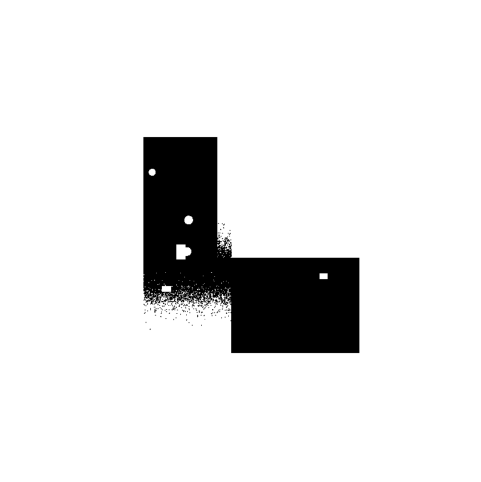

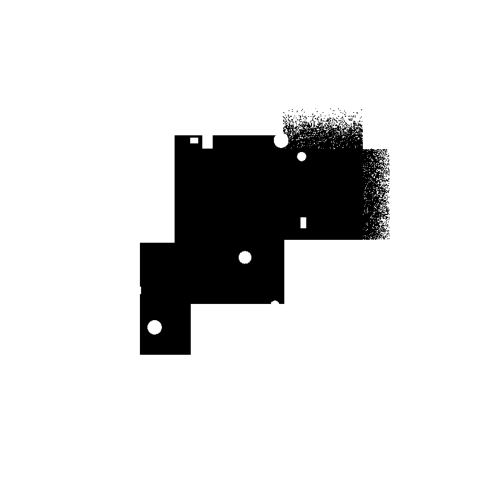

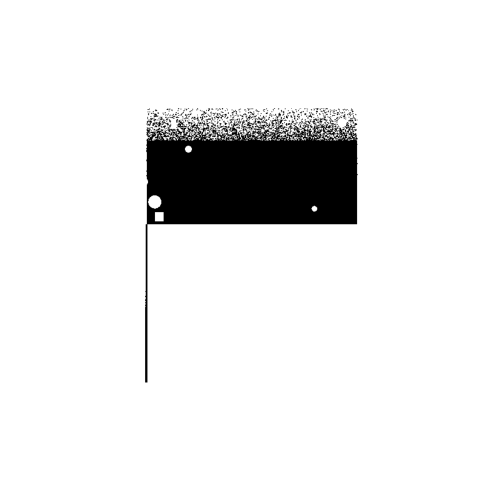

In [12]:
import random
def process_images():
    for i in range(100):
        # Generate a random shape
        shape = random_shape()
        
        # Plot the shape (this step may be optional based on whether you need to view the plot or just generate the image)
        plt.figure(figsize=(6, 6))

        # Create a filled binary image of the shape
        #binary_image = create_filled_binary_image(shape)
        
        # Create an image with noise added on a random ammount of edges
        # Generate two random numbers between 0 and 3
        num1 = random.randint(0, 4)
        num2 = random.randint(0, 4)
        image_with_noise = create_image_with_noise(shape, (num1, num2), num_points=10000, noise_radius=0.1, figsize=(10, 10))
        
        # Add random shapes to the noisy image
        image_with_furniture = add_random_shapes_to_image(image_with_noise)
        image_with_furniture_np_array = np.array(image_with_furniture, dtype=int)
        plt.imshow(image_with_furniture_np_array, cmap='gray')
        plt.axis('off')  # Nascondi gli assi
        plt.show()
        plt.close
process_images()
